밑바닥부터 시작하는 딥러닝 2
# 2.4 통계 기반 기법 개선하기

## 상호정보량

동시발생 행렬: 발생 횟수 중심 -> ex) the와 car이 동시 발생하는 횟수가 많다고 관련성이 높게 나오는 문제점 -> 점별 상호정보량(PMI 척도 사용

PMI: 확률 x, y에 대해서 log2(동시에 일어날 확률 / 확률 x가 일어날 확률 * 확률 y가 일어날 확률) -> PMI값 이 높을수록 관련성이 높음
* 자연어에서는 단어 x가 말뭉치에 등장할 확률로 해석
* 단어가 단독으로 출현하는 횟수도 고려 (ex. the가 단독으로 출현하는 횟수가 많아 car는 the 보다 drive와 관련이 높게 나오게 됨)

-> 두 단어의 동시발생 횟수가 0이면 -무한대 가 된다는 문제점 -> 양의 상호정보량 (PPMI) 사용 : PMI가 음수일 때는 0으로 취급

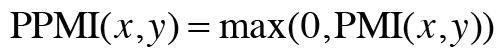

In [1]:
def ppmi(C, verbose = True, eps = 1e-8):
    M = np.zeros_like(C, dtype = np.float32)
    N = np.sum()
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% 완료' % (100*cnt/total))
    return M

* C: 동시발생 행렬, verbose: 진해상황 출력 여부, eps: np.log2(0)가 -inf가 되는 사태를 피하기 위해

In [2]:
import sys
sys.path.append('/Users/sungahwang/Desktop/DL/DLfromScratch2')
import numpy as np
from common.util import preprocess, create_co_matrix, cos_similarity, ppmi

In [3]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

In [4]:
np.set_printoptions(precision = 3)
print('동시발생 행렬')
print(C)
print('-' * 50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


* 말뭉치의 어휘 수가 증가함에 따라 각 단어 벡터의 차원 수도 증가한다는 문제점(ex. 말뭉치 어휘 수가 10만개라면 10만 차원)
* 원소 대부분이 0으로 중요도가 낮음
* 노이즈에 약함

-> 차원 감소 필요

## 차원 감소

중요한 정보는 최대한 유지하면서 차원을 줄이는 것이 핵심

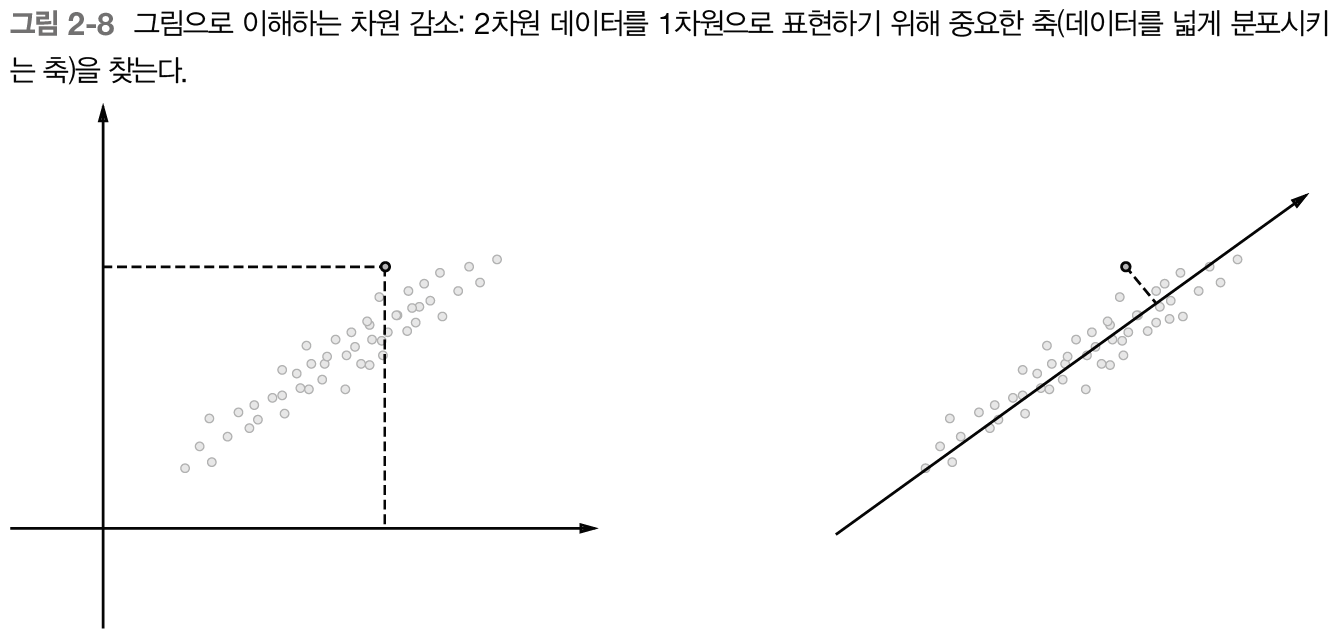

* 희소벡터(원소 대부분이0)에서 중요한 축을 찾아내어 더 적은 차원으로 표현 (원소 대부분이 0이 아닌 밀집벡터)

특잇값분해(singular value decomposition: SVD)

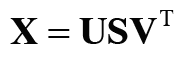

* 행렬 X를 U, S, V라는 세 행렬의 곱으로 분해
* U와 V는 직교행렬
* S는 대각행렬(대각성분 외에 모두0)

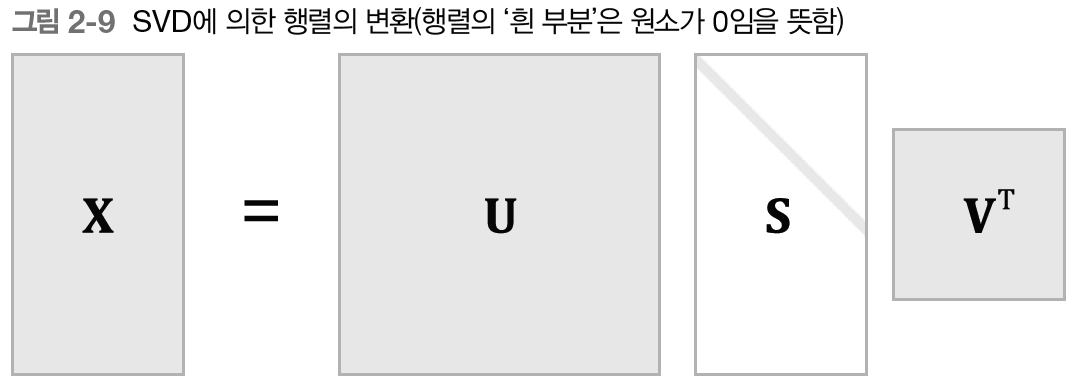

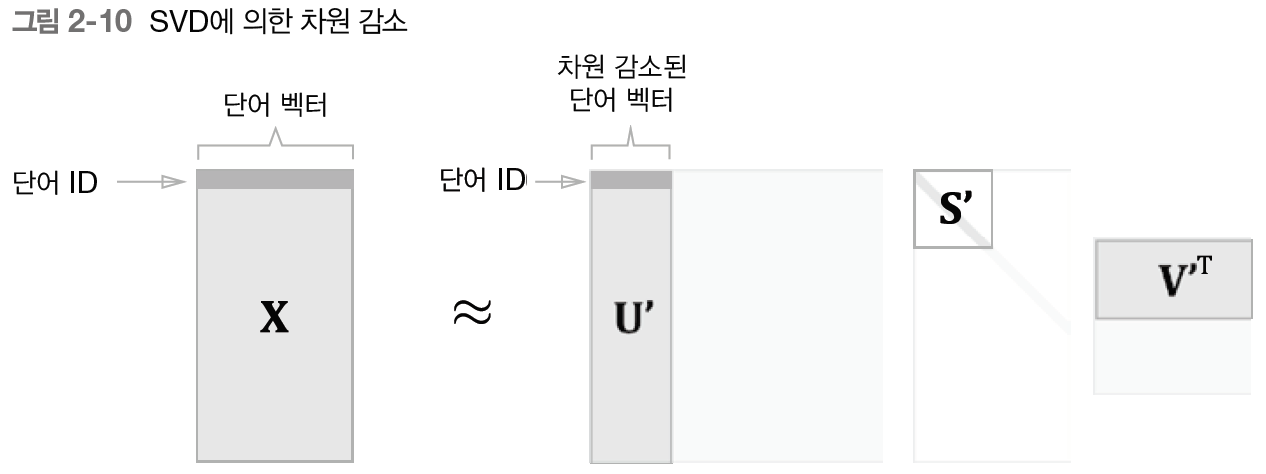

* U(직교행렬) 가 기저(공간을 span하는 벡터) 형성
* S(대각행렬): 특이값(중요도) 큰 순서로나열 -> 중요도가 낮은 원소를 깎아내는 방법

## SVD에 의한 차원 감소

In [5]:
import sys
sys.path.append('/Users/sungahwang/Desktop/DL/DLfromScratch2')
import numpy as np
import matplotlib.pyplot as plt
from common.util import preprocess, create_co_matrix, ppmi

In [6]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

In [7]:
# SVD
U, S, V = np.linalg.svd(W)

In [8]:
print(U[0]) # SVD

[ 3.409e-01 -1.110e-16 -3.886e-16 -1.205e-01 -9.323e-01  0.000e+00
 -1.800e-16]


* 밀집 벡터

In [9]:
print(U[0, :2])

[ 3.409e-01 -1.110e-16]


* 2차원 벡터로 줄이려면 처음 두 원소 추출

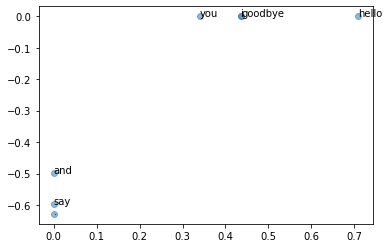

In [10]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:, 0], U[:, 1], alpha= 0.5)
plt.show()

## PTB 데이터셋

In [11]:
import sys
sys.path.append('/Users/sungahwang/Desktop/DL/DLfromScratch2')
from data import ptb

In [12]:
corpus, word_to_id, id_to_word = ptb.load_data('train')

In [13]:
print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


## PTB 데이터셋 평가

In [14]:
import sys
sys.path.append('/Users/sungahwang/Desktop/DL/DLfromScratch2')
import numpy as np
from common.util import most_similar, create_co_matrix, ppmi
from data import ptb

In [15]:
window_size = 2
wordvec_size = 100


corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')

C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose = True)

print('SVD 계산 ...')

try:
    # truncated SVD (빠름)
    from sklearn.utils.extmath import randomsized_svd
    U, S, V = randomized_svd(W, n_components = wordvec_size, n_iter = 5,
                            random_sate  = None)
except ImportError:
    # SVD (느림)
    U, S, V = np.linalg.svd(W)
    
word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top = 5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
SVD 계산 ...

[query] you
 i: 0.7003179788589478
 we: 0.6367185115814209
 anybody: 0.565764248

* truncated SVD: 특이값이 큰 것들만 계산하여 기본적인 SVD보다 빠름(무작위 수 사용)